In [15]:
#Misc
import signal
import sys
sys.path.append("../../")
from utils import *
import utils
#Torch
import torch
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.autograd import Variable
#Numpy-Matplotlib-tqdm-sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
#DynamicalSystems
from DynamicalSystems.kernels import Linear, RBF
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression

In [2]:
num_classes = 10
perm_data = build_sequential_data(num_classes=num_classes)

In [3]:
num_train_samples = 1000
num_val_samples = 200
torch_dataset = torch.from_numpy(data[perm_data])
dataset = data[perm_data]
X = dataset[:-1].reshape(-1, 28 * 28)
Y = dataset[1:].reshape(-1, 28*28)
CV = False

#### Optimizing Linear Hyperparameters

In [4]:
tsCV = TimeSeriesSplit(n_splits=2, max_train_size=num_train_samples)
d = X.shape[1]
tikhonov_regs = np.geomspace(1e0, 1e2, 20)
tikhonov_reg_linear = 48.3293 #CV
gamma_linear = d**-1 #CV
gammas = np.geomspace((d**-1)*1e-3, d**-1*(1e1), 20)
params = list(
    ParameterGrid(
        { 
            #'tikhonov_reg': tikhonov_regs, 
            #'gamma': gammas,
        }
    )
)
backend = 'cpu'

In [5]:
if CV:
    error = np.empty((len(params), 2))
    for iter_idx, iterate in tqdm(enumerate(params), total=len(params)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            kernel = Linear(gamma=gamma_linear)
            model = KernelRidgeRegression(kernel, tikhonov_reg = tikhonov_reg_linear)
                
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, 0] = np.mean(_err)
        error[iter_idx, 1] = np.std(_err)

In [6]:
if CV:
    fig, ax = plt.subplots()     
    mean = error[:,0]
    std = error[:,1]
    ax.fill_between(coef0, mean - std, mean + std, alpha = 0.5)
    ax.plot(coef0, mean, '.-')
    ax.margins(0)
    ax.set_ylabel("Test error")
    ax.set_xscale('log')
    ax.set_yscale('log')

#### Optimizing RBF's hyperparameters

In [7]:
tsCV = TimeSeriesSplit(n_splits=2, max_train_size=num_train_samples)
d = X.shape[1]
tikhonov_regs = np.geomspace(1e-8, 1e-1, 20)
tikhonov_reg_RBF = 0.00785 #CV
length_scales = np.geomspace(d*1e-8, d*1e3, 20)
params = list(
    ParameterGrid(
        { 
            'tikhonov_reg': tikhonov_regs, 
            #'length_scale': length_scales,
        }
    )
)
backend = 'cpu'

In [8]:
if CV:
    error = np.empty((len(params), 2))
    for iter_idx, iterate in tqdm(enumerate(params), total=len(params)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            kernel = RBF(length_scale=d)
            model = KernelRidgeRegression(kernel, tikhonov_reg = iterate['tikhonov_reg'])
            
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, 0] = np.mean(_err)
        error[iter_idx, 1] = np.std(_err)

In [9]:
if CV:
    fig, ax = plt.subplots()     
    mean = error[:,0]
    std = error[:,1]
    ax.fill_between(tikhonov_regs, mean - std, mean + std, alpha = 0.5)
    ax.plot(tikhonov_regs, mean, '.-')
    ax.margins(0)
    ax.set_ylabel("Test error")
    ax.set_xscale('log')
    ax.set_yscale('log')

#### Train CNN-Kernel

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization

def classifier_train(num_epochs, cnn, loader):
    
    cnn.train()
        
    # Train the model
    total_step = len(loader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                  
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))

In [11]:
cnn_train_samples = num_train_samples
images = (torch_dataset[:(cnn_train_samples + 1)])[:,None,...]
targets = utils._train_data.targets[perm_data][:cnn_train_samples + 1]
dataset = TensorDataset(images, targets)
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=1)
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)  

In [12]:
classifier_train(20, cnn, loader)

Epoch [1/20], Loss: 0.0017
Epoch [2/20], Loss: 0.0008
Epoch [3/20], Loss: 0.5772
Epoch [4/20], Loss: 0.0004
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0095
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.0192
Epoch [9/20], Loss: 0.0000
Epoch [10/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0007
Epoch [15/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0029
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0001


In [13]:
num_features = 512
tikhonov_reg_NN = 1e-6
net = CNN(num_features=num_features).to(device)
params = {'epochs': 5000}
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6)
torch_train_data = (torch_dataset[:(num_train_samples+1)])[:,None,...]

TypeError: __init__() got an unexpected keyword argument 'num_features'

In [75]:
train(torch_train_data, net, optimizer, params, tikhonov_reg_NN, norm_reg=1, split_size=0)

Loss: 2.46e+01 | Norm: 2.46e+01:  51%|█████     | 2562/5000 [08:46<08:21,  4.87Epoch/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 8.53 GiB already allocated; 10.81 MiB free; 9.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Text(0, 0.5, 'Norm')

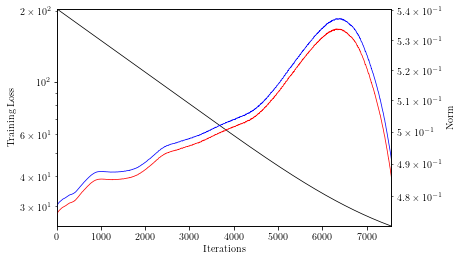

In [76]:
_norms = np.array(net._norm_history)
cov_norm_XY = _norms[:,0]
cov_norm_X  = _norms[:,1]
params_norm = _norms[:,2]
fig, ax1 = plt.subplots()
skip_num = 0
ax1.plot(np.array(net._loss_history)[skip_num:], 'k-', markersize=1, lw=0.75)
ax2 = ax1.twinx()
ax2.plot(np.array(cov_norm_XY)[skip_num:], 'r-', markersize=1, lw=0.75)
ax2.plot(np.array(cov_norm_X)[skip_num:], 'b-', markersize=1, lw=0.75)
ax1.margins(0)
#ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training Loss")
ax2.set_ylabel("Norm")

In [77]:
evals = np.array([e.detach().cpu().numpy() for e in net._evals_history])
evals = np.abs(np.array(evals))

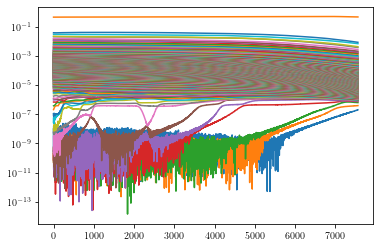

In [78]:
plt.plot(evals)
plt.yscale('log')

In [16]:
cnn_kernel(Y_train)

array([[9.9983585e-01, 7.5187279e-09, 3.7839302e-06, ..., 9.7879660e-10,
        7.5734642e-06, 1.1318457e-06],
       [7.5187279e-09, 9.9995041e-01, 8.0369205e-09, ..., 4.1659710e-08,
        2.1965801e-05, 1.6996010e-08],
       [3.7839302e-06, 8.0369205e-09, 9.9992180e-01, ..., 8.9290984e-11,
        2.9539926e-05, 2.7238032e-09],
       ...,
       [9.7879660e-10, 4.1659710e-08, 8.9290984e-11, ..., 9.9987221e-01,
        6.5903955e-10, 7.1244533e-05],
       [7.5734642e-06, 2.1965801e-05, 2.9539926e-05, ..., 6.5903955e-10,
        9.9988365e-01, 7.4106293e-07],
       [1.1318457e-06, 1.6996010e-08, 2.7238032e-09, ..., 7.1244533e-05,
        7.4106293e-07, 9.9893075e-01]], dtype=float32)

### Learning with Linear, RBF and DeepKernel

In [16]:
cnn_kernel = DeepKernel(cnn, softmax=True)
kernels = [Linear(gamma=gamma_linear), RBF(length_scale =28*28), cnn_kernel]
tikhonov_regs = [tikhonov_reg_linear, tikhonov_reg_RBF, 1e-4]
trained_estimators = []
for k_idx, kernel in enumerate(kernels):
    K = ReducedRankRegression(kernel=kernel, rank=10, tikhonov_reg=tikhonov_regs[k_idx])
    X_train = X[:num_train_samples]
    Y_train = Y[:num_train_samples] 
    K.fit(X_train, Y_train, backend="cpu")
    trained_estimators.append(K)

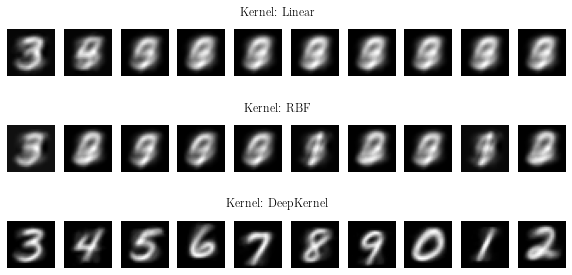

In [19]:
fig = plt.figure(constrained_layout=False, figsize=(10,4))
X_0 = X[num_train_samples + 0*num_classes + 3][None, :].reshape(28,28)
_img_data = []
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(trained_estimators), ncols=1)
for row, subfig in enumerate(subfigs):
    estimator = trained_estimators[row]
    _kernel_name = estimator.kernel.__class__.__name__
    subfig.suptitle(f"Kernel: {_kernel_name}")
    axs = subfig.subplots(nrows=1, ncols=num_classes)
    _imgs = [X_0]
    for col, ax in enumerate(axs):
        ax.axis('off')
        X_val = _imgs[-1].reshape(1, 28*28)
        Y_val = estimator.predict(X_val)
        Y_val = np.squeeze(Y_val).reshape(28,28)
        _imgs.append(Y_val)
        ax.imshow(Y_val, cmap="gray")
    _img_data.append(_imgs)
plt.subplots_adjust(hspace=0)
_img_data = np.array(_img_data)

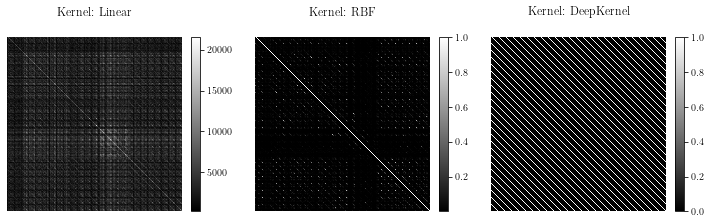

In [56]:
fig = plt.figure(constrained_layout=True, figsize=(10,3))
axs = fig.subplots(nrows=1, ncols=len(trained_estimators))
for col, ax in enumerate(axs):
    ax.axis('off')
    ker_plot = ax.matshow(trained_estimators[col].K_X, cmap="gray")
    ax.set_title(f"Kernel: {trained_estimators[col].kernel.__class__.__name__}")
    fig.colorbar(ker_plot, ax=ax)


In [25]:
np.save("_img_data.npy", _img_data)